# Пример использования Synthetic Augmentation Generator
В данном ноутбуке приведен пример использования генератора синтетической аугментации изображений, а так же рассмотрен результат его работы

In [12]:
import os
import json
from PIL import Image
from syntgenerator import AugmentationGenerator

Для работы с генератором нужно подготовить JSON файл с ббоксами и промптами в формате:

    {
        "classes": [
            {
                "id": 0,
                "label": "label_0",
                "prompts": [
                    "prompt №1 for label_0",
                    "prompt №2 for label_0",
                    ...
                ]
            },
            ...
        ],
        "bboxs": [
            [x_min_0, y_min_0, x_max_0, y_max_0],
            [x_min_1, y_min_1, x_max_1, y_max_1],
            ...
        ]
    }
Укажем пути до всех необходимых данных и весов модели, которая будет использоваться в inpaint пайплайне 

In [ ]:
dir_images = './data/original/' #путь до оригинальных изображений
dir_dataset = './data/synt-dataset/' #путь до сгенерированного датасета
source_json = './data/original.json' #путь до JSON файла с ббоксами и промптами
final_json = './data/synt-dataset.json' #путь до JSON файла со сгенерированной COCO разметкой

model = 'stabilityai/stable-diffusion-2-inpainting' #название модели

generator = AugmentationGenerator(source_json=source_json, 
                                  dir_images=dir_images, 
                                  dir_dataset=dir_dataset, 
                                  final_json=final_json, 
                                  weights=model)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
generator(guidance_scale=10, 
          num_inference_steps=50, 
          bb_num=1)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

В данном примере использовались 5 изображений, на каждом из которых было сгенерировано по одному bbox'у. Теперь посмотрим на результат работы генератора. В первой колонке будут вырезанные фрагменты из оригинальных изображений, а во второй из аугментированных.

In [13]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

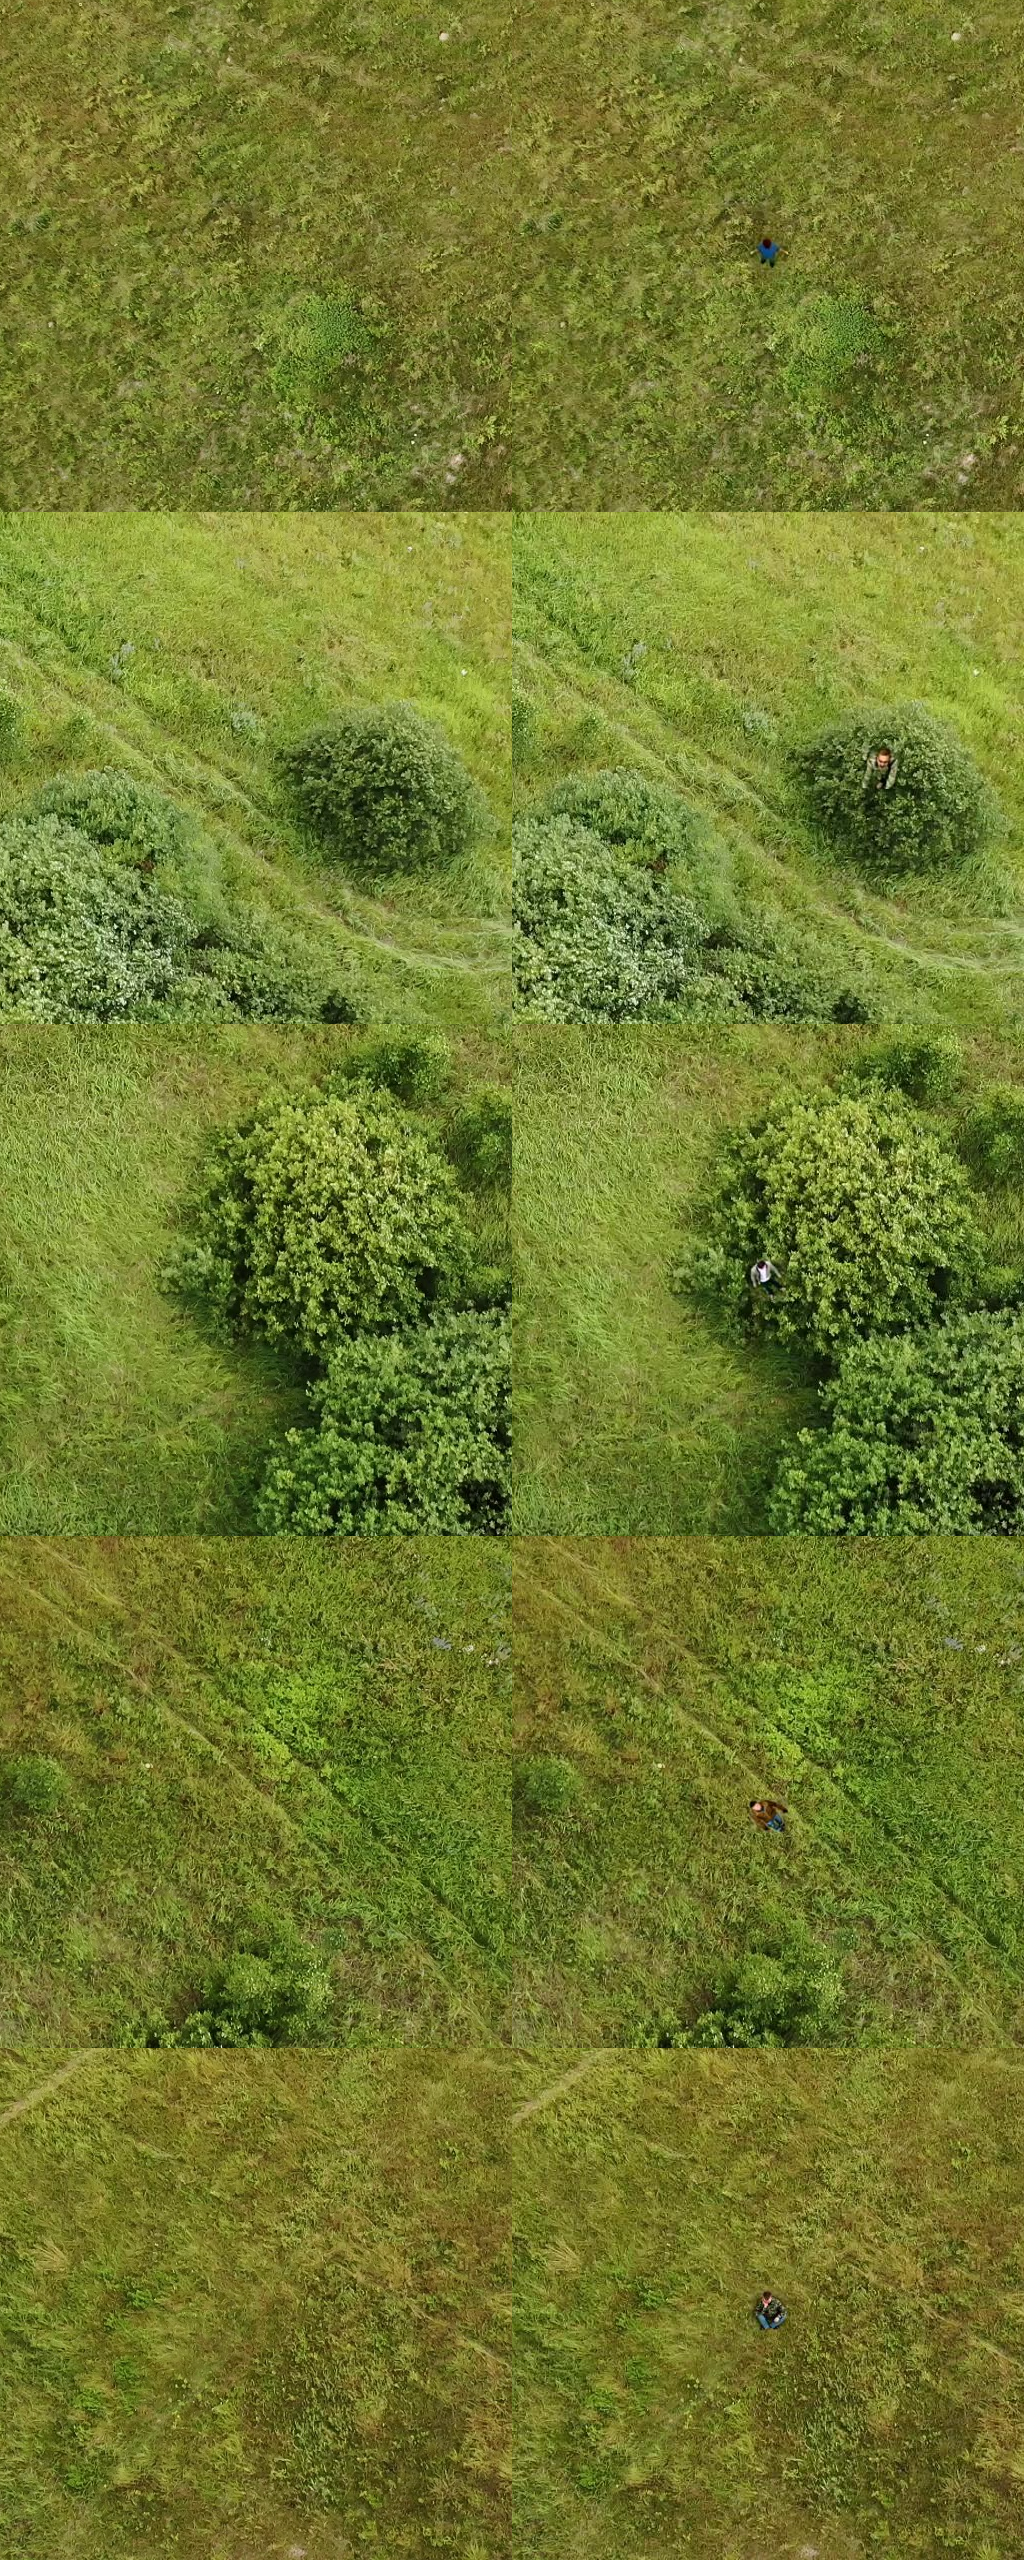

In [15]:
results = []
with open(final_json, 'r') as f:
    coco = json.load(f)
    for ann in coco['annotations']:
            img_name = coco['images'][ann['image_id']]['file_name'].split('/')[-1]
            original_img = Image.open(dir_images + img_name)
            augmented_img = Image.open(dir_dataset + img_name)
            w, h = original_img.size
            bbox = ann['bbox']
            bbox[2] += bbox[0]
            bbox[3] += bbox[1]
            orig_att_area, _, _, _ = AugmentationGenerator.generate_attention_area(img=original_img, bbox=bbox, aa_size=512)
            aug_att_area, _, _, _ = AugmentationGenerator.generate_attention_area(img=augmented_img, bbox=bbox, aa_size=512)
            results += [orig_att_area, aug_att_area]

image_grid(results, 5, 2)

Так же доступно использование через CLI:

In [ ]:
!synt-generator --source_json './data/original.json' \
                --final_json './data/synt-dataset.json' \
                --dir_images './data/original/' \
                --dir_dataset './data/synt-dataset/' \
                --weights '../../2-custom-inpaint-v1'